# Shakespeare
The aim of this notebook is to study:
1. The "emotional profile" of each characher in the whole play, according to both a categorical and dimensional theory of emotions;
2. The evolution inside the play of each charachter, i.e. for each charachter, we investigate its "emotional evolution" throughout the story;
3. Characters interactions

In [1]:
import pandas as pd
from nrclex import NRCLex
import os
import zipfile
import nltk
from tqdm import tqdm
from transformers import pipeline
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.emotion_model import EmotionModel
import plotly.express as px
from statsmodels.tsa.stattools import grangercausalitytests
import spacy
import networkx as nx

## 1. Emotional Profile of the Characters


In [2]:
df = pd.read_csv("./data.nosync/romeo_juliet_pre_processed.csv")

In [3]:
df["ActScene"] = df["Act"].astype(str)+"."+df["Scene"].astype(str)

In [4]:
df.head()

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,ActScene
0,80499,85284,Romeo and Juliet,7.0,1.0.1,RICHMOND,"Two households, both alike in dignity,",1,0,1.0
1,80500,85285,Romeo and Juliet,7.0,1.0.2,RICHMOND,"In fair Verona, where we lay our scene,",1,0,1.0
2,80501,85286,Romeo and Juliet,7.0,1.0.3,RICHMOND,"From ancient grudge break to new mutiny,",1,0,1.0
3,80502,85287,Romeo and Juliet,7.0,1.0.4,RICHMOND,Where civil blood makes civil hands unclean.,1,0,1.0
4,80503,85288,Romeo and Juliet,7.0,1.0.5,RICHMOND,From forth the fatal loins of these two foes,1,0,1.0


### 1.1 Profile in the whole play

In [5]:
# Define the classifier
classifier = EmotionModel('bhadresh-savani/distilbert-base-uncased-emotion')

/Users/federicobassi/.conda/envs/text_mining_sent_analysis/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [6]:
characters = df["Player"].unique()

In [7]:
characters

array(['RICHMOND', 'SAMPSON', 'GREGORY', 'ABRAHAM', 'TYBALT', 'BENVOLIO',
       'First Citizen', 'CAPULET', 'LADY CAPULET', 'MONTAGUE',
       'LADY MONTAGUE', 'PRINCE', 'ROMEO', 'PARIS', 'Servant', 'Nurse',
       'JULIET', 'MERCUTIO', 'First Servant', 'Second Servant',
       'Second Capulet', 'Chorus', 'FRIAR LAURENCE', 'PETER', 'NURSE',
       'LADY  CAPULET', 'First Musician', 'Second Musician', 'Musician',
       'BALTHASAR', 'Apothecary', 'FRIAR JOHN', 'PAGE', 'First Watchman',
       'Second Watchman', 'Third Watchman'], dtype=object)

In [8]:
# Define the list of emotions that the classifier uses
emotions_list = classifier.get_emotion_list()
emotions_list

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [9]:
df.head()

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,ActScene
0,80499,85284,Romeo and Juliet,7.0,1.0.1,RICHMOND,"Two households, both alike in dignity,",1,0,1.0
1,80500,85285,Romeo and Juliet,7.0,1.0.2,RICHMOND,"In fair Verona, where we lay our scene,",1,0,1.0
2,80501,85286,Romeo and Juliet,7.0,1.0.3,RICHMOND,"From ancient grudge break to new mutiny,",1,0,1.0
3,80502,85287,Romeo and Juliet,7.0,1.0.4,RICHMOND,Where civil blood makes civil hands unclean.,1,0,1.0
4,80503,85288,Romeo and Juliet,7.0,1.0.5,RICHMOND,From forth the fatal loins of these two foes,1,0,1.0


In [10]:
df["emotion"] = df["PlayerLine"].apply(lambda x: classifier.get_emotion_label(x))

In [11]:
df.loc[(df["Player"]=="ROMEO") & (df["Act"]==4)]

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,ActScene,emotion


In [12]:
df_count = pd.DataFrame(df.groupby(by=["Player", "emotion"])["Scene"].count()).reset_index().rename(columns={"Scene":"count"})

In [13]:
df_count

,Player,emotion,count
0,ABRAHAM,anger,2
1,Apothecary,anger,5
2,Apothecary,joy,1
3,BALTHASAR,anger,13
4,BALTHASAR,fear,2
...,...,...,...
111,TYBALT,fear,1
112,TYBALT,joy,4
113,TYBALT,love,1
114,TYBALT,sadness,1


In [14]:
df_grouped = df_count.groupby('Player')['count'].sum()
df_grouped

Player
ABRAHAM              2
Apothecary           6
BALTHASAR           22
BENVOLIO           106
CAPULET            172
Chorus              11
FRIAR JOHN          11
FRIAR LAURENCE     267
First Citizen        2
First Musician       4
First Servant        4
First Watchman      10
GREGORY             11
JULIET             373
LADY  CAPULET        1
LADY CAPULET        73
LADY MONTAGUE        2
MERCUTIO           177
MONTAGUE            30
Musician             1
NURSE                6
Nurse              147
PAGE                 7
PARIS               53
PETER               21
PRINCE              48
RICHMOND            14
ROMEO              441
SAMPSON             23
Second Capulet       2
Second Musician      4
Second Servant       7
Second Watchman      1
Servant             17
TYBALT              24
Third Watchman       2
Name: count, dtype: int64

In [15]:
df_count['count_normalized'] = df_count['count'] / df_count['Player'].map(df_grouped)

In [16]:
df_count

,Player,emotion,count,count_normalized
0,ABRAHAM,anger,2,1.000000
1,Apothecary,anger,5,0.833333
2,Apothecary,joy,1,0.166667
3,BALTHASAR,anger,13,0.590909
4,BALTHASAR,fear,2,0.090909
...,...,...,...,...
111,TYBALT,fear,1,0.041667
112,TYBALT,joy,4,0.166667
113,TYBALT,love,1,0.041667
114,TYBALT,sadness,1,0.041667


In [17]:
df_count.loc[df_count["Player"]=="ROMEO"]

,Player,emotion,count,count_normalized
93,ROMEO,anger,184,0.417234
94,ROMEO,fear,17,0.038549
95,ROMEO,joy,165,0.374150
96,ROMEO,love,29,0.065760
97,ROMEO,sadness,46,0.104308


In [18]:
df_count.loc[df_count["Player"]=="JULIET"]

,Player,emotion,count,count_normalized
44,JULIET,anger,164,0.439678
45,JULIET,fear,19,0.050938
46,JULIET,joy,145,0.388740
47,JULIET,love,15,0.040214
48,JULIET,sadness,30,0.080429


In [ ]:
categories = list(df_count.emotion.unique())
fig = go.Figure()
fig.add_trace(go.Scatterpolar(
    r=list(df_count.loc[df_count["Player"]=="ROMEO", "count"]),
    theta=list(df_count.loc[df_count["Player"]=="ROMEO", "emotion"]),
    fill="toself",
    name="Romeo"
))

fig.add_trace(go.Scatterpolar(
    r=list(df_count.loc[df_count["Player"]=="JULIET", "count"]),
    theta=list(df_count.loc[df_count["Player"]=="JULIET", "emotion"]),
    fill="toself",
    name="Juliet"
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True
)

fig.show()


In [20]:
def plot_sentence_emotions(sentence):
    data = classifier.get_emotions(sentence)
    print(data)
    labels = [entry['label'] for entry in data]
    scores = [entry['score'] for entry in data]

    df = pd.DataFrame({'Labels': labels, 'Scores': scores})
    color_palette = {'sadness': 'blue', 'joy': 'green', 'love': 'pink',
                 'anger': 'red', 'fear': 'orange', 'surprise': 'purple'}
    
    sns.histplot(data=df, x='Labels', weights='Scores', multiple='stack')
    plt.xlabel('Emotion Labels')
    plt.ylabel('Score')
    plt.title(sentence,fontsize=20)
    plt.xticks(rotation=45)
    
    for patch, label in zip(plt.gca().patches, labels):
        patch.set_facecolor(color_palette[label])
    
    plt.show()

[{'label': 'sadness', 'score': 0.8793439269065857}, {'label': 'joy', 'score': 0.011455317959189415}, {'label': 'love', 'score': 0.002546009374782443}, {'label': 'anger', 'score': 0.06917063146829605}, {'label': 'fear', 'score': 0.035605739802122116}, {'label': 'surprise', 'score': 0.0018784039421007037}]


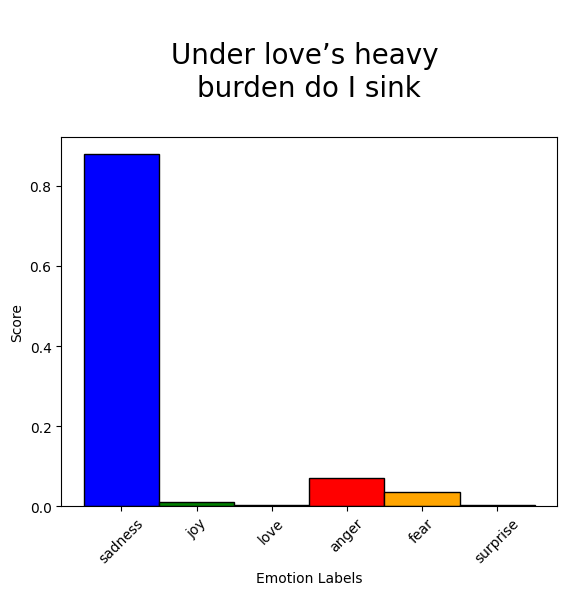

In [21]:
plot_sentence_emotions("""
Under love’s heavy 
burden do I sink
""")

[{'label': 'sadness', 'score': 0.0008622245513834059}, {'label': 'joy', 'score': 0.0006688630674034357}, {'label': 'love', 'score': 0.00031690046307630837}, {'label': 'anger', 'score': 0.9971137046813965}, {'label': 'fear', 'score': 0.0008061783737502992}, {'label': 'surprise', 'score': 0.00023214647080749273}]


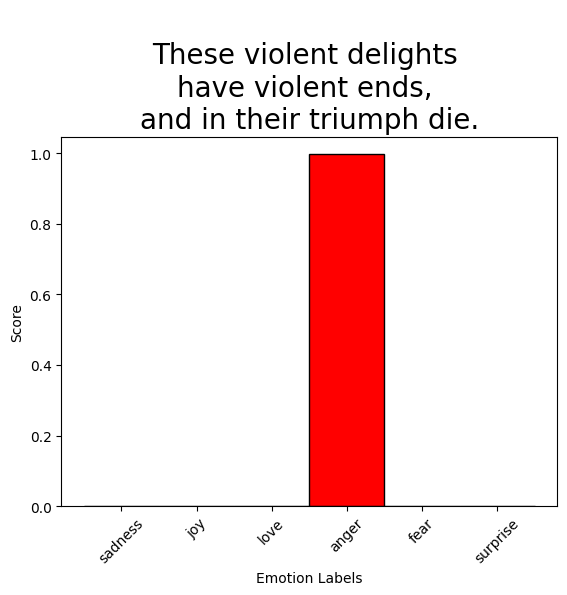

In [22]:
plot_sentence_emotions("""
These violent delights 
have violent ends, 
and in their triumph die.""")

[{'label': 'sadness', 'score': 0.014794304035604}, {'label': 'joy', 'score': 0.9407474398612976}, {'label': 'love', 'score': 0.004154238849878311}, {'label': 'anger', 'score': 0.03356190770864487}, {'label': 'fear', 'score': 0.005337018519639969}, {'label': 'surprise', 'score': 0.0014052246697247028}]


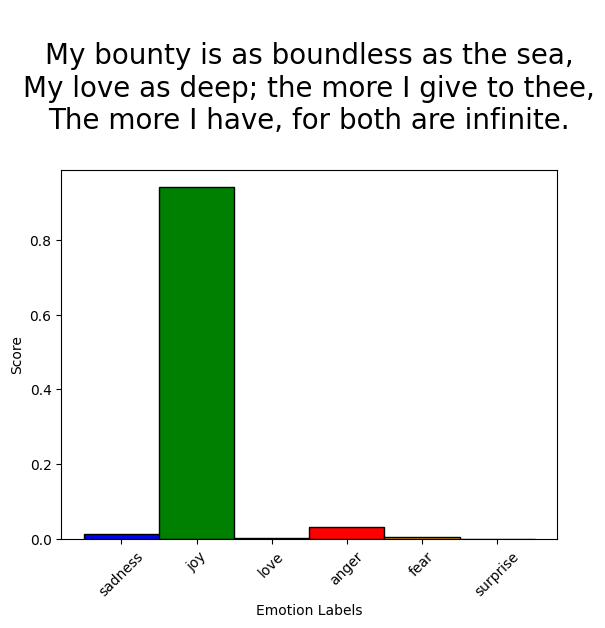

In [23]:
plot_sentence_emotions("""
My bounty is as boundless as the sea,
My love as deep; the more I give to thee,
The more I have, for both are infinite.
""")

### 2. Evolution of characters through the play

In [24]:
df_count = pd.DataFrame(df.groupby(by=["Player", "emotion", "Act"])["Dataline"].count()).reset_index().rename(columns={"Dataline":"count"})

In [25]:
df_grouped = df_count.groupby(['Player', "Act"])['count'].sum()

In [26]:
df_count["count_normalized"] = df_count["count"] / df_count.set_index(['Player', 'Act']).index.map(df_grouped)

In [27]:
df_count

,Player,emotion,Act,count,count_normalized
0,ABRAHAM,anger,1,2,1.000000
1,Apothecary,anger,5,5,0.833333
2,Apothecary,joy,5,1,0.166667
3,BALTHASAR,anger,5,13,0.590909
4,BALTHASAR,fear,5,2,0.090909
...,...,...,...,...,...
227,TYBALT,fear,1,1,0.062500
228,TYBALT,joy,3,4,0.500000
229,TYBALT,love,1,1,0.062500
230,TYBALT,sadness,1,1,0.062500


In [28]:
romeo = df_count.loc[(df_count.Player=="ROMEO")].sort_values("Act")
juliet = df_count.loc[(df_count.Player=="JULIET")].sort_values("Act")

In [29]:
romeo

,Player,emotion,Act,count,count_normalized
191,ROMEO,anger,1,33,0.297297
207,ROMEO,sadness,1,20,0.180180
195,ROMEO,fear,1,4,0.036036
203,ROMEO,love,1,12,0.108108
199,ROMEO,joy,1,42,0.378378
208,ROMEO,sadness,2,6,0.047619
204,ROMEO,love,2,9,0.071429
200,ROMEO,joy,2,58,0.460317
196,ROMEO,fear,2,6,0.047619
192,ROMEO,anger,2,47,0.373016


In [30]:
juliet

,Player,emotion,Act,count,count_normalized
77,JULIET,anger,1,5,0.312500
91,JULIET,love,1,2,0.125000
86,JULIET,joy,1,8,0.500000
82,JULIET,fear,1,1,0.062500
95,JULIET,sadness,2,9,0.079646
92,JULIET,love,2,7,0.061947
87,JULIET,joy,2,50,0.442478
78,JULIET,anger,2,44,0.389381
83,JULIET,fear,2,3,0.026549
84,JULIET,fear,3,6,0.040268


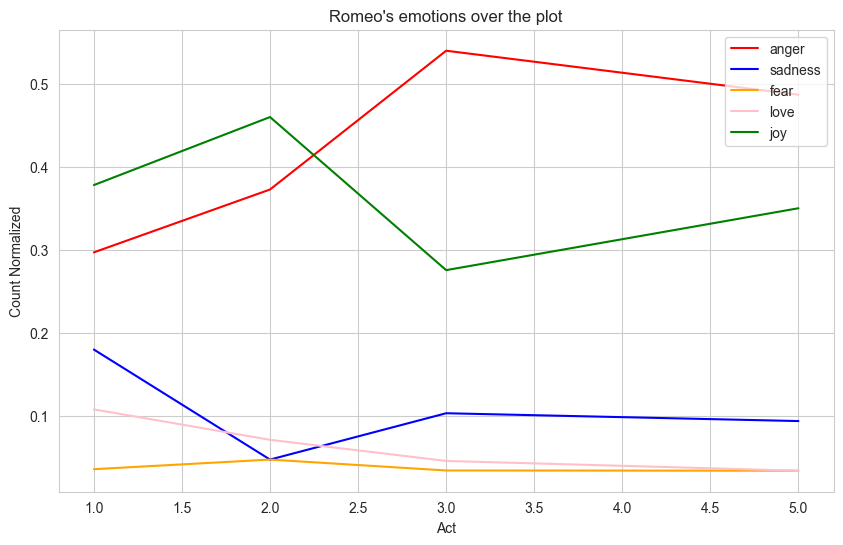

In [31]:
color_palette = {'sadness': 'blue', 'joy': 'green', 'love': 'pink',
                 'anger': 'red', 'fear': 'orange', 'surprise': 'purple'}
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(x="Act", y="count_normalized", hue="emotion", data=romeo, palette=color_palette)
plt.xlabel("Act")
plt.ylabel("Count Normalized")
plt.title("Romeo's emotions over the plot")
plt.legend(loc='upper right')
plt.show()

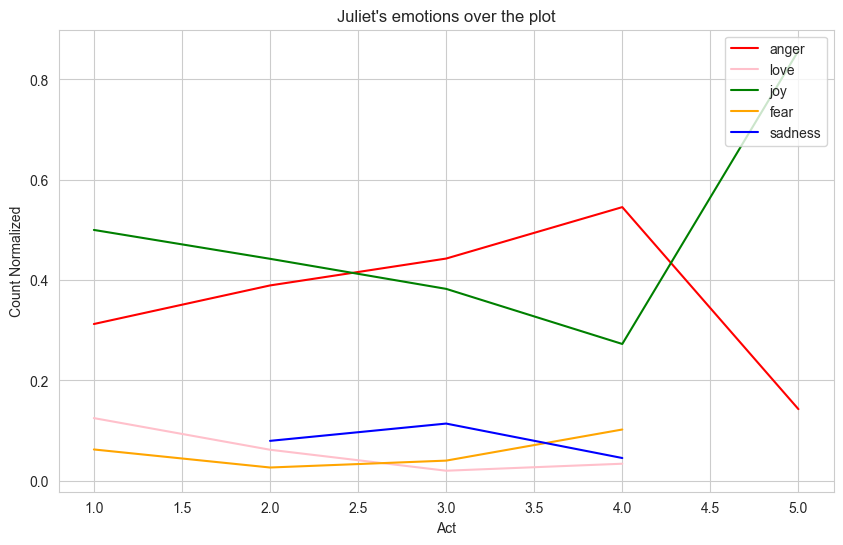

In [32]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(x="Act", y="count_normalized", hue="emotion", data=juliet, palette = color_palette)

plt.xlabel("Act")
plt.ylabel("Count Normalized")
plt.title("Juliet's emotions over the plot")
plt.legend(loc='upper right')
plt.show()

### 3. Charachers interaction through the play
#### 3.1 Granger causality
We study the interaction of the characters in the play by performing a Granger causality test on the temporal series of each charachter for each of their emotions.

In [33]:
df_count = pd.DataFrame(df.groupby(by=["Player", "emotion", "ActScene"])["Scene"].count()).reset_index().rename(columns={"Scene":"count"})

In [34]:
df_count

,Player,emotion,ActScene,count
0,ABRAHAM,anger,1.1,2
1,Apothecary,anger,5.1,5
2,Apothecary,joy,5.1,1
3,BALTHASAR,anger,5.1,2
4,BALTHASAR,anger,5.3,11
...,...,...,...,...
358,TYBALT,fear,1.5,1
359,TYBALT,joy,3.1,4
360,TYBALT,love,1.5,1
361,TYBALT,sadness,1.5,1


In [35]:
df_grouped = df_count.groupby(['Player', "ActScene"])['count'].sum()

In [36]:
df_grouped

Player          ActScene
ABRAHAM         1.1          2
Apothecary      5.1          6
BALTHASAR       5.1          8
                5.3         14
BENVOLIO        1.1         31
                            ..
Servant         1.3          4
TYBALT          1.1          3
                1.5         13
                3.1          8
Third Watchman  5.3          2
Name: count, Length: 115, dtype: int64

In [37]:
df_count

,Player,emotion,ActScene,count
0,ABRAHAM,anger,1.1,2
1,Apothecary,anger,5.1,5
2,Apothecary,joy,5.1,1
3,BALTHASAR,anger,5.1,2
4,BALTHASAR,anger,5.3,11
...,...,...,...,...
358,TYBALT,fear,1.5,1
359,TYBALT,joy,3.1,4
360,TYBALT,love,1.5,1
361,TYBALT,sadness,1.5,1


In [38]:
df_count["count_normalized"] = df_count["count"] / df_count.set_index(['Player', 'ActScene']).index.map(df_grouped)

In [39]:
df_count

,Player,emotion,ActScene,count,count_normalized
0,ABRAHAM,anger,1.1,2,1.000000
1,Apothecary,anger,5.1,5,0.833333
2,Apothecary,joy,5.1,1,0.166667
3,BALTHASAR,anger,5.1,2,0.250000
4,BALTHASAR,anger,5.3,11,0.785714
...,...,...,...,...,...
358,TYBALT,fear,1.5,1,0.076923
359,TYBALT,joy,3.1,4,0.500000
360,TYBALT,love,1.5,1,0.076923
361,TYBALT,sadness,1.5,1,0.076923


In [40]:
romeo = df_count.loc[(df_count.Player=="ROMEO")].sort_values("ActScene")
juliet = df_count.loc[(df_count.Player=="JULIET")].sort_values("ActScene")

In [41]:
romeo

,Player,emotion,ActScene,count,count_normalized
278,ROMEO,anger,1.1,11,0.244444
300,ROMEO,joy,1.1,14,0.311111
325,ROMEO,sadness,1.1,12,0.266667
291,ROMEO,fear,1.1,1,0.022222
314,ROMEO,love,1.1,7,0.155556
...,...,...,...,...,...
290,ROMEO,anger,5.3,30,0.483871
313,ROMEO,joy,5.3,24,0.387097
324,ROMEO,love,5.3,2,0.032258
299,ROMEO,fear,5.3,2,0.032258


In [42]:
juliet

,Player,emotion,ActScene,count,count_normalized
113,JULIET,anger,1.3,1,0.200000
143,JULIET,love,1.3,1,0.200000
132,JULIET,joy,1.3,3,0.600000
114,JULIET,anger,1.5,4,0.363636
144,JULIET,love,1.5,1,0.090909
133,JULIET,joy,1.5,5,0.454545
124,JULIET,fear,1.5,1,0.090909
115,JULIET,anger,2.2,33,0.417722
150,JULIET,sadness,2.2,6,0.075949
145,JULIET,love,2.2,5,0.063291


In [43]:
df

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,ActScene,emotion
0,80499,85284,Romeo and Juliet,7.0,1.0.1,RICHMOND,"Two households, both alike in dignity,",1,0,1.0,anger
1,80500,85285,Romeo and Juliet,7.0,1.0.2,RICHMOND,"In fair Verona, where we lay our scene,",1,0,1.0,joy
2,80501,85286,Romeo and Juliet,7.0,1.0.3,RICHMOND,"From ancient grudge break to new mutiny,",1,0,1.0,anger
3,80502,85287,Romeo and Juliet,7.0,1.0.4,RICHMOND,Where civil blood makes civil hands unclean.,1,0,1.0,anger
4,80503,85288,Romeo and Juliet,7.0,1.0.5,RICHMOND,From forth the fatal loins of these two foes,1,0,1.0,anger
...,...,...,...,...,...,...,...,...,...,...,...
2097,83588,88587,Romeo and Juliet,64.0,5.3.315,CAPULET,Poor sacrifices of our enmity!,5,3,5.3,sadness
2098,83589,88588,Romeo and Juliet,65.0,5.3.316,PRINCE,"A glooming peace this morning with it brings,",5,3,5.3,sadness
2099,83590,88589,Romeo and Juliet,65.0,5.3.317,PRINCE,"The sun, for sorrow, will not show his head:",5,3,5.3,sadness
2100,83591,88590,Romeo and Juliet,65.0,5.3.318,PRINCE,"Go hence, to have more talk of these sad things,",5,3,5.3,sadness


In [44]:
test = pd.DataFrame({"ActScene":df["ActScene"].unique()})

for emotion in df_count["emotion"].unique():
    for char in ["ROMEO", "JULIET"]:
        tmp = df_count.loc[(df_count["Player"]==char) & (df_count["emotion"]==emotion), ["ActScene","count_normalized"]].rename(columns={"count_normalized":f"{char}_{emotion}"})
        test = test.merge(tmp, how="left", on="ActScene")

In [45]:
test

,ActScene,ROMEO_anger,JULIET_anger,ROMEO_joy,JULIET_joy,ROMEO_fear,JULIET_fear,ROMEO_love,JULIET_love,ROMEO_sadness,JULIET_sadness,ROMEO_surprise,JULIET_surprise
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.1,0.244444,NaN,0.311111,NaN,0.022222,NaN,0.155556,NaN,0.266667,NaN,NaN,NaN
2,1.2,0.315789,NaN,0.526316,NaN,NaN,NaN,0.052632,NaN,0.105263,NaN,NaN,NaN
3,1.3,NaN,0.200000,NaN,0.600000,NaN,NaN,NaN,0.200000,NaN,NaN,NaN,NaN
4,1.4,0.409091,NaN,0.318182,NaN,0.090909,NaN,0.045455,NaN,0.136364,NaN,NaN,NaN
5,1.5,0.280000,0.363636,0.440000,0.454545,0.040000,0.090909,0.120000,0.090909,0.120000,NaN,NaN,NaN
6,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.1,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN
8,2.2,0.389831,0.417722,0.406780,0.430380,0.067797,0.012658,0.101695,0.063291,0.033898,0.075949,NaN,NaN
9,2.3,0.300000,NaN,0.450000,NaN,0.100000,NaN,0.100000,NaN,0.050000,NaN,NaN,NaN


In [47]:
maxlag = 1
def grangers_causation_matrix(data, variables, test='ssr_chi2test'):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            #if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [46]:
granger = test[["ActScene","ROMEO_anger", "JULIET_joy"]].dropna()
granger

,ActScene,ROMEO_anger,JULIET_joy
5,1.5,0.280000,0.454545
8,2.2,0.389831,0.430380
12,2.6,0.250000,0.400000
17,3.5,0.421053,0.391892
25,5.3,0.483871,0.857143


In [48]:
results = grangers_causation_matrix(granger, granger.columns)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=2, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=1
parameter F test:         F=32.5054 , p=0.0294  , df_denom=2, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1971  , p=0.4714  , df_denom=1, df_num=1
ssr based chi2 test:   chi2=4.7886  , p=0.0286  , df=1
likelihood ratio test: chi2=3.1486  , p=0.0760  , df=1
parameter F test:         F=1.1971  , p=0.4714  , df_denom=1, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6328  , p=0.2539  , df_denom=1, df_num=1
ssr based chi2 test:   chi2=22.5311 , p=0.0000  , df=1
likelihood ratio test: chi2=7.5681  , p=0.0059  , df=1
parameter F test:         F=5.6328  , p=0.2539  , df_denom=1, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0177  , p=0.9158  , df_denom=1

In [63]:
results.to_excel("anger_joy.xlsx")

----

#### 3.2 Social network

In [50]:
df.head()

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,ActScene,emotion
0,80499,85284,Romeo and Juliet,7.0,1.0.1,RICHMOND,"Two households, both alike in dignity,",1,0,1.0,anger
1,80500,85285,Romeo and Juliet,7.0,1.0.2,RICHMOND,"In fair Verona, where we lay our scene,",1,0,1.0,joy
2,80501,85286,Romeo and Juliet,7.0,1.0.3,RICHMOND,"From ancient grudge break to new mutiny,",1,0,1.0,anger
3,80502,85287,Romeo and Juliet,7.0,1.0.4,RICHMOND,Where civil blood makes civil hands unclean.,1,0,1.0,anger
4,80503,85288,Romeo and Juliet,7.0,1.0.5,RICHMOND,From forth the fatal loins of these two foes,1,0,1.0,anger


In [51]:
characters

array(['RICHMOND', 'SAMPSON', 'GREGORY', 'ABRAHAM', 'TYBALT', 'BENVOLIO',
       'First Citizen', 'CAPULET', 'LADY CAPULET', 'MONTAGUE',
       'LADY MONTAGUE', 'PRINCE', 'ROMEO', 'PARIS', 'Servant', 'Nurse',
       'JULIET', 'MERCUTIO', 'First Servant', 'Second Servant',
       'Second Capulet', 'Chorus', 'FRIAR LAURENCE', 'PETER', 'NURSE',
       'LADY  CAPULET', 'First Musician', 'Second Musician', 'Musician',
       'BALTHASAR', 'Apothecary', 'FRIAR JOHN', 'PAGE', 'First Watchman',
       'Second Watchman', 'Third Watchman'], dtype=object)

In [52]:
def check_characters(sentence, characters):
    sentence = sentence.lower()
    lst = [char for char in characters if char.lower() in sentence]
    if len(lst)==1:
        return lst[0]
    else:
        return ""

In [53]:
df["Referenced"] = df["PlayerLine"].apply(lambda x: check_characters(x, characters))

In [54]:
df

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,ActScene,emotion,Referenced
0,80499,85284,Romeo and Juliet,7.0,1.0.1,RICHMOND,"Two households, both alike in dignity,",1,0,1.0,anger,
1,80500,85285,Romeo and Juliet,7.0,1.0.2,RICHMOND,"In fair Verona, where we lay our scene,",1,0,1.0,joy,
2,80501,85286,Romeo and Juliet,7.0,1.0.3,RICHMOND,"From ancient grudge break to new mutiny,",1,0,1.0,anger,
3,80502,85287,Romeo and Juliet,7.0,1.0.4,RICHMOND,Where civil blood makes civil hands unclean.,1,0,1.0,anger,
4,80503,85288,Romeo and Juliet,7.0,1.0.5,RICHMOND,From forth the fatal loins of these two foes,1,0,1.0,anger,
...,...,...,...,...,...,...,...,...,...,...,...,...
2097,83588,88587,Romeo and Juliet,64.0,5.3.315,CAPULET,Poor sacrifices of our enmity!,5,3,5.3,sadness,
2098,83589,88588,Romeo and Juliet,65.0,5.3.316,PRINCE,"A glooming peace this morning with it brings,",5,3,5.3,sadness,
2099,83590,88589,Romeo and Juliet,65.0,5.3.317,PRINCE,"The sun, for sorrow, will not show his head:",5,3,5.3,sadness,
2100,83591,88590,Romeo and Juliet,65.0,5.3.318,PRINCE,"Go hence, to have more talk of these sad things,",5,3,5.3,sadness,


In [55]:
df[df["PlayerLine"].str.contains('Romeo', case=False)]

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,ActScene,emotion,Referenced
117,80670,85469,Romeo and Juliet,67.0,1.1.157,BENVOLIO,It was. What sadness lengthens Romeo's hours?,1,1,1.1,sadness,ROMEO
216,80806,85611,Romeo and Juliet,11.0,1.2.55,BENVOLIO,"Why, Romeo, art thou mad?",1,2,1.2,anger,ROMEO
450,81151,85972,Romeo and Juliet,19.0,1.5.67,TYBALT,"'Tis he, that villain Romeo.",1,5,1.5,anger,ROMEO
544,81293,86126,Romeo and Juliet,9.0,2.1.41,MERCUTIO,"Romeo, good night: I'll to my truckle-bed,",2,1,2.1,joy,ROMEO
569,81332,86169,Romeo and Juliet,4.0,2.2.35,JULIET,"O Romeo, Romeo! wherefore art thou Romeo?",2,2,2.2,anger,ROMEO
648,81445,86285,Romeo and Juliet,34.0,2.2.148,JULIET,"Three words, dear Romeo, and good night indeed.",2,2,2.2,joy,ROMEO
663,81470,86313,Romeo and Juliet,42.0,2.2.173,JULIET,With repetition of my Romeo's name.,2,2,2.2,anger,ROMEO
720,81544,86392,Romeo and Juliet,3.0,2.3.43,FRIAR LAURENCE,Our Romeo hath not been in bed to-night.,2,3,2.3,anger,ROMEO
764,81599,86450,Romeo and Juliet,1.0,2.4.1,MERCUTIO,Where the devil should this Romeo be?,2,4,2.4,anger,ROMEO
767,81607,86458,Romeo and Juliet,6.0,2.4.9,BENVOLIO,Romeo will answer it.,2,4,2.4,anger,ROMEO


In [56]:
df_graph = df[df["Referenced"]!=""]
df_graph.head()

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,ActScene,emotion,Referenced
14,80514,85300,Romeo and Juliet,1.0,1.1.1,SAMPSON,"Gregory, o' my word, we'll not carry coals.",1,1,1.1,anger,GREGORY
18,80520,85306,Romeo and Juliet,7.0,1.1.7,SAMPSON,A dog of the house of Montague moves me.,1,1,1.1,anger,MONTAGUE
22,80524,85310,Romeo and Juliet,9.0,1.1.11,SAMPSON,take the wall of any man or maid of Montague's.,1,1,1.1,anger,MONTAGUE
24,80529,85315,Romeo and Juliet,11.0,1.1.16,SAMPSON,"Montague's men from the wall, and thrust his m...",1,1,1.1,anger,MONTAGUE
34,80543,85329,Romeo and Juliet,18.0,1.1.30,GREGORY,two of the house of the Montagues.,1,1,1.1,anger,MONTAGUE


In [64]:
G = nx.MultiDiGraph()
G.add_edges_from([(tupla[0],tupla[1], {"emotion":tupla[2]}) for tupla in list(zip(df_graph["Player"], df_graph["Referenced"], df_graph["emotion"]))])

[0,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 0,
 2,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 3,
 3,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 3,
 2,
 2,
 3,
 4,
 4,
 5,
 2,
 0,
 3,
 4,
 5,
 6,
 2,
 7,
 0,
 1,
 0,
 1,
 3,
 1,
 0,
 1,
 3,
 0,
 4,
 5,
 0,
 4,
 2,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 0,
 8,
 9,
 10,
 0,
 2,
 4,
 0,
 0,
 11,
 12,
 0,
 1,
 1,
 0,
 3,
 4,
 0,
 1,
 3,
 13,
 14,
 15,
 3,
 4,
 16,
 17,
 0,
 2,
 4,
 1,
 0,
 3,
 2,
 0,
 0,
 1,
 6,
 0,
 0,
 1,
 5,
 0,
 1,
 7,
 8,
 5,
 9,
 1,
 3,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 6,
 3,
 7,
 1,
 8,
 0,
 0,
 0,
 2,
 0]

In [65]:
nx.write_gexf(G = G, path = "romeo_juliet.gexf")